In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
os.environ["TORCH_CUDA_ARCH_LIST"] = "8.9"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

import supervision as sv
from supervision.draw.color import ColorPalette

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [2]:
from sam2.sam2_image_predictor import SAM2ImagePredictor
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

os.environ["TORCH_CUDA_ARCH_LIST"] = "8.9"

def load_models(dino_id="IDEA-Research/grounding-dino-base", sam2_id="facebook/sam2-hiera-large"):
    mask_predictor = SAM2ImagePredictor.from_pretrained(sam2_id, device=device)
    grounding_processor = AutoProcessor.from_pretrained(dino_id)
    grounding_model = AutoModelForZeroShotObjectDetection.from_pretrained(dino_id).to(device)
    
    return mask_predictor, grounding_processor, grounding_model

mask_predictor, grounding_processor, grounding_model = load_models()

In [3]:
object_list = ["table", "chair"]
text_prompt = ". ".join(object_list) + "."
text_prompt

'table. chair.'

In [4]:
from tqdm import tqdm
import rospy
import rosbag
from cv_bridge import CvBridge
import pathlib
import cv2

from bytetrack.byte_tracker import BYTETracker

In [5]:
from types import SimpleNamespace
# args for BYTETracker
args = SimpleNamespace(**{
        "track_thresh": 0.40,
        "track_buffer": 90,
        "match_thresh": 0.75,
        "mot20": False,
        "min_box_area": 100,
})

(-0.5, 1919.5, 639.5, -0.5)

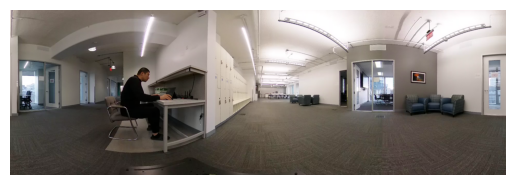

In [6]:
img_dir = "/home/chadwick/Downloads/extracted/image_mod"
img_dir = pathlib.Path(img_dir)
img_paths = list(img_dir.glob("*.png"))
img_paths = sorted(img_paths)

# draw the first image
img = cv2.imread(str(img_paths[0]))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

In [7]:
tracker = BYTETracker(args)

In [ ]:
for img_path in tqdm(img_paths, desc="Processing images"):
    image = Image.open(img_path)
    image = np.array(image.convert("RGB"))

    inputs = grounding_processor(
        images=image,
        text=text_prompt,
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        outputs = grounding_model(**inputs)

    results = grounding_processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        # box_threshold=0.25,
        # text_threshold=0.25,
        target_sizes=[image.shape[:2]],
    )

    class_names = np.array(results[0]["labels"])
    input_boxes = results[0]["boxes"].cpu().numpy()  # (n_boxes, 4)
    confidences = results[0]["scores"].cpu().numpy()  # (n_boxes,)
    detection_data = np.hstack((input_boxes, confidences.reshape(-1, 1)))

    class_ids = np.array(list(range(len(class_names))))

    labels = [
        f"{class_name} {confidence:.2f}"
        for class_name, confidence in zip(class_names, confidences)
    ]

    detections = sv.Detections(
        xyxy=input_boxes,  # (n, 4)
        class_id=class_ids,
    )

    box_annotator = sv.BoxAnnotator(color=ColorPalette.DEFAULT)
    annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections)

    label_annotator = sv.LabelAnnotator(color=ColorPalette.DEFAULT)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame, detections=detections, labels=labels
    )

    online_targets = tracker.update(detection_data, class_names)
    online_tlwhs = []
    online_tlbrs = []
    # onlin_orig_bboxes = []
    online_ids = []
    online_scores = []
    online_class_names = []

    for t in online_targets:
        tlwh = t.tlwh
        tlbr = t.tlbr
        orig_bbox = t.tlwh_to_tlbr(t._tlwh)
        tid = t.track_id
        if tlwh[2] * tlwh[3] > args.min_box_area:
            online_tlwhs.append(tlwh)
            # onlin_orig_bboxes.append(orig_bbox)
            online_tlbrs.append(tlbr)
            online_ids.append(tid)
            online_scores.append(t.score)
            online_class_names.append(t.class_name)

    # sam2
    mask_predictor.set_image(image)

    if len(online_tlbrs) > 0:
        online_masks, _, _ = mask_predictor.predict(
            point_coords=None,
            point_labels=None,
            box=np.array(online_tlbrs),
            multimask_output=False,
        )

        if online_masks.ndim == 4:
            online_masks = online_masks.squeeze(1)

        class_ids = np.array(list(range(len(online_class_names))))

    if len(online_ids) > 0:
        detections = sv.Detections(
            xyxy=np.array(online_tlbrs),
            mask=online_masks.astype(bool),
            class_id=class_ids,
        )

        annotated_frame_1 = box_annotator.annotate(
            scene=image.copy(), detections=detections
        )

        labels = [
            f"{class_name} {id} {confidence:.2f}"
            for class_name, id, confidence in zip(
                online_class_names, online_ids, online_scores
            )
        ]

        annotated_frame_1 = label_annotator.annotate(
            scene=annotated_frame_1, detections=detections, labels=labels
        )

        mask_annotator = sv.MaskAnnotator(color=ColorPalette.DEFAULT)
        annotated_frame_1 = mask_annotator.annotate(
            scene=annotated_frame_1, detections=detections
        )
    else:
        annotated_frame_1 = image.copy()
        print("No objects detected")

    # show the annotated frame using cv2
    final_frame = np.vstack((annotated_frame, annotated_frame_1))
    # final_frame = cv2.cvtColor(final_frame, cv2.COLOR_RGB2BGR)
    # cv2.imshow("Annotated Frame", final_frame)

    # if cv2.waitKey(1) & 0xFF == ord("q"):
    #     break

    # save annotated frame, numpy array h x w x 3
    try:
        img_dir = pathlib.Path("/home/chadwick/Downloads/image_s")
        img_dir.mkdir(exist_ok=True)
        Image.fromarray(final_frame).save(img_dir / f"{img_path.stem}.png")
    except Exception as e:
        print(f"Error saving image: {e}")

    # save class_names, input_boxes, masks, and confidences into npz file
    npz_dir = pathlib.Path("/home/chadwick/Downloads/image_npz")
    npz_dir.mkdir(exist_ok=True)
    np.savez_compressed(
        npz_dir / f"{img_path.stem}.npz",
        labels=np.array(online_class_names),
        bboxes=np.array(online_tlbrs),
        masks=online_masks,
        confidences=np.array(online_scores),
        ids=np.array(online_ids),
    )


Processing images:   1%|          | 21/2999 [00:15<35:50,  1.38it/s] 


KeyboardInterrupt: 